In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, Subset
import torchvision
import os
import cv2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from Function import *
import joblib
import seaborn as sns
%matplotlib inline

2026-01-13 21:53:02,949	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.5.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

### VAE model

In [3]:
class Args:
  pass

args = Args()
args.batch_size = 64
args.epochs = 20
args.cuda = True
args.log_interval = 10
args.model = 'optimal_sigma_vae'  # Which model to use:  mse_vae,  gaussian_vae, or sigma_vae or optimal_sigma_vae

if not torch.cuda.is_available():
  args.cuda = False

vae = SigmaVAE(device, 3, args)

In [4]:
vae.load_state_dict(torch.load('./model_save/VAE.pt'))

<All keys matched successfully>

### Diffusion model

In [5]:
diffusion = Diffusion(PretrainedConfig())
diffusion.load_state_dict(torch.load('./model_save/diffusVAE.pt'))

<All keys matched successfully>

In [6]:
def generate(n, device, out_vae):
    #Generation starting from random noise
    image = torch.randn(n, 3, 128, 128, device=device)
    
    mean = diffusion.norm.running_mean.reshape(1, 3, 1, 1)
    std = (diffusion.norm.running_var**0.5).reshape(1, 3, 1, 1)

    #Generation 20 steps
    for i in range(20):
        time = torch.full(size=(n, 1, 1, 1),
                          fill_value=(20 - i) / 20,
                          dtype=torch.float32,
                          device=device)

        #Random coefficients
        noise_r, image_r = schedule(time)

        #Combine noise image and noise coefficients
        #[b, 64, 64, 64]
        combine = diffusion.combine(image, noise_r**2, out_vae)

        #Predict noise from noise image
        pred_noise = diffusion.unet(combine)

        #Restore image based on predicted noise
        pred_image = (image - noise_r * pred_noise) / image_r

        #Recalculate random coefficients
        time = time - (1 / 20)
        noise_r, image_r = schedule(time)

        #Add noise back to the image for the next step calculation
        image = image_r * pred_image + noise_r * pred_noise

    pred_image = mean + pred_image * std
    pred_image = pred_image.clip(0.0, 1.0)
    
        
    return out_vae, pred_image

### Latent space dimensionality reduction

In [7]:
z_pd = pd.read_csv("./z_i.csv", index_col=0)
z_pd.shape

(2000, 128)

In [8]:
z_np = np.array(z_pd).reshape(25,80,128)

z_mean = np.mean(z_np, axis=1)
z_std = np.std(z_np, axis=1)

In [9]:
from sklearn.decomposition import PCA
pca_mean = PCA(n_components=3, svd_solver='arpack')
pca_mean.fit(z_mean)
z_mean_pca = pca_mean.transform(z_mean)

pca_std = PCA(n_components=3, svd_solver='arpack')
pca_std.fit(z_std)
z_std_pca = pca_std.transform(z_std)

### Construction of prediction models

In [10]:
# from scipy import stats 
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [11]:
original_data = pd.read_csv('./dataset.csv')

In [12]:
X = np.concatenate([z_mean_pca[:, :3], z_std_pca[:, :3]], axis=1)

y_ys = original_data['Yield strength (MPa)']
y_el = original_data['Elongation (%)']

In [13]:
seed = 75
X_train, X_test, y_train_1, y_test_1 = train_test_split(X, y_ys, test_size=0.2, random_state=seed)

In [14]:
# Prediction of yield strength
regressor_1 = GradientBoostingRegressor()
regressor_1 = joblib.load('./model_save/GBR_ys.pkl')

y_pred_train_1 = regressor_1.predict(X_train)
y_pred_test_1 = regressor_1.predict(X_test)
print(r2(y_pred_train_1, y_train_1), r2(y_pred_test_1, y_test_1))

0.9441932488366491 0.9564997377697353


In [15]:
X_train, X_test, y_train_2, y_test_2 = train_test_split(X, y_el, test_size=0.2, random_state=seed)

In [16]:
# Prediction of elongation
regressor_2 = GradientBoostingRegressor()
regressor_2 = joblib.load('./model_save/GBR_el.pkl')

y_pred_train_2 = regressor_2.predict(X_train)
y_pred_test_2 = regressor_2.predict(X_test)
print(r2(y_pred_train_2, y_train_2), r2(y_pred_test_2, y_test_2))

0.8753432903924282 0.863375470642789


### Multi-objective optimization

In [17]:
from pymoo.core.problem import ElementwiseProblem
class MyProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=6, 
                         n_obj=2, 
                         n_constr=0, 
                         xl=np.array([-2, -2, -2, -2, -2, -2]), 
                         xu=np.array([2, 2, 2, 2, 2, 2]))

    def _evaluate(self, x, out, *args, **kwargs):
        y_1 = regressor_1.predict(np.array(x).reshape(1, -1))
        y_2 = regressor_2.predict(np.array(x).reshape(1, -1))
        out["F"] = [-y_1.item(), -y_2.item()]


In [18]:
from pymoo.core.callback import Callback

class MyCallback(Callback):
    def __init__(self):
        super().__init__()
        self.data["gen"] = []
        self.data["pop"] = []
        self.data["hist_X"] = []
        self.data["hist_crowding"] = []

    def notify(self, algorithm):
        self.data["gen"].append(algorithm.n_gen)
        self.data["pop"].append(algorithm.pop.get("F"))
        self.data["hist_X"].append(algorithm.pop.get("X"))
        self.data["hist_crowding"].append(algorithm.pop.get("crowding"))

problem = MyProblem()

# Configure the NSGA-II algorithm
algorithm = NSGA2(pop_size=10, save_history=True)

# Run optimization
callback = MyCallback()

seed = 212

res = minimize(problem,
               algorithm,
               ('n_gen', 500),
               callback=callback,
               seed=seed,
               verbose=True)

# Extract Pareto front
pareto_front = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      3 |             - |             -
     2 |       20 |      6 |  0.0394600511 |         nadir
     3 |       30 |     10 |  0.0186117527 |             f
     4 |       40 |     10 |  0.000000E+00 |             f
     5 |       50 |     10 |  0.000000E+00 |             f
     6 |       60 |     10 |  0.0079757128 |             f
     7 |       70 |      8 |  0.0176414985 |         nadir
     8 |       80 |     10 |  0.0038404443 |             f
     9 |       90 |     10 |  0.0019017639 |             f
    10 |      100 |     10 |  0.0019017639 |             f
    11 |      110 |     10 |  0.0019017639 |             f
    12 |      120 |     10 |  0.0019017639 |             f
    13 |      130 |     10 |  0.0019017639 |             f
    14 |      140 |     10 |  0.0019017639 |             f
    15 |      150 |     10 |  0.0019017639 |             f
    16 |      160 |     10 |  0.0019017639 |            

   162 |     1620 |     10 |  0.000000E+00 |             f
   163 |     1630 |     10 |  0.000000E+00 |             f
   164 |     1640 |     10 |  0.000000E+00 |             f
   165 |     1650 |     10 |  0.000000E+00 |             f
   166 |     1660 |     10 |  0.000000E+00 |             f
   167 |     1670 |     10 |  0.000000E+00 |             f
   168 |     1680 |     10 |  0.000000E+00 |             f
   169 |     1690 |     10 |  0.000000E+00 |             f
   170 |     1700 |     10 |  0.000000E+00 |             f
   171 |     1710 |     10 |  0.000000E+00 |             f
   172 |     1720 |     10 |  0.000000E+00 |             f
   173 |     1730 |     10 |  0.000000E+00 |             f
   174 |     1740 |     10 |  0.000000E+00 |             f
   175 |     1750 |     10 |  0.000000E+00 |             f
   176 |     1760 |     10 |  0.000000E+00 |             f
   177 |     1770 |     10 |  0.000000E+00 |             f
   178 |     1780 |     10 |  0.000000E+00 |            

   305 |     3050 |     10 |  0.0000421804 |             f
   306 |     3060 |     10 |  0.0000421804 |             f
   307 |     3070 |     10 |  0.0000421804 |             f
   308 |     3080 |     10 |  0.0000421804 |             f
   309 |     3090 |     10 |  0.0000421804 |             f
   310 |     3100 |     10 |  0.0000421804 |             f
   311 |     3110 |     10 |  0.0000421804 |             f
   312 |     3120 |     10 |  0.0000421804 |             f
   313 |     3130 |     10 |  0.0000421804 |             f
   314 |     3140 |     10 |  0.0000421804 |             f
   315 |     3150 |     10 |  0.0000421804 |             f
   316 |     3160 |     10 |  0.0000421804 |             f
   317 |     3170 |     10 |  0.0000421804 |             f
   318 |     3180 |     10 |  0.0000421804 |             f
   319 |     3190 |     10 |  0.0000421804 |             f
   320 |     3200 |     10 |  0.0000421804 |             f
   321 |     3210 |     10 |  0.0000421804 |            

   452 |     4520 |     10 |  0.0000421804 |             f
   453 |     4530 |     10 |  0.0000421804 |             f
   454 |     4540 |     10 |  0.0000421804 |             f
   455 |     4550 |     10 |  0.0000421804 |             f
   456 |     4560 |     10 |  0.0000421804 |             f
   457 |     4570 |     10 |  0.0000421804 |             f
   458 |     4580 |     10 |  0.0000421804 |             f
   459 |     4590 |     10 |  0.0000421804 |             f
   460 |     4600 |     10 |  0.0000421804 |             f
   461 |     4610 |     10 |  0.0000421804 |             f
   462 |     4620 |     10 |  0.0000421804 |             f
   463 |     4630 |     10 |  0.0000421804 |             f
   464 |     4640 |     10 |  0.0000421804 |             f
   465 |     4650 |     10 |  0.0000421804 |             f
   466 |     4660 |     10 |  0.0000421804 |             f
   467 |     4670 |     10 |  0.0000421804 |             f
   468 |     4680 |     10 |  0.0000421804 |            

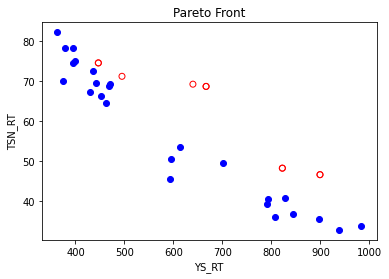

In [19]:
# Pareto front
plt.figure()
plt.scatter(y_ys, y_el, c='blue')
plt.scatter(-pareto_front[:, 0], -pareto_front[:, 1], facecolor="none", edgecolor="red")
    
plt.xlabel('YS_RT')
plt.ylabel('TSN_RT')
plt.title('Pareto Front')
plt.show()

In [20]:
mu_pateto = pca_mean.inverse_transform(res.X[:, :3])
std_pateto = pca_std.inverse_transform(res.X[:, 3:])

In [21]:
sample_list = []
for j in range(10):
    samples = []
    for i in range(128):
        samples.append(np.random.normal(mu_pateto[j][i], std_pateto[j][i], 80))
    sample_list.append(samples)
z_pateto = np.array(sample_list)
y_pateto = np.concatenate([-res.F[:, 0].reshape(10,1), -res.F[:, 1].reshape(10,1)], axis=1)

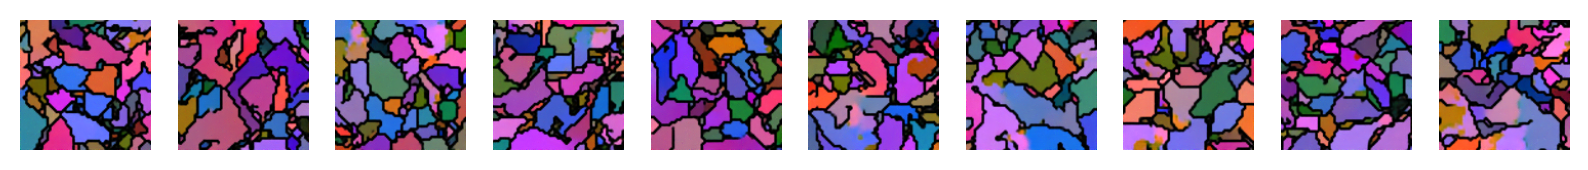

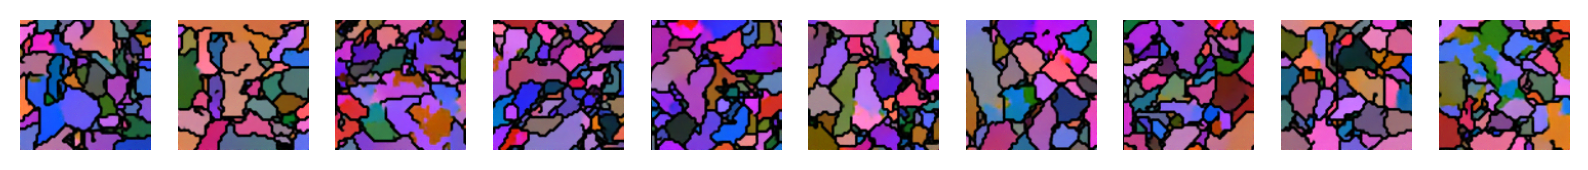

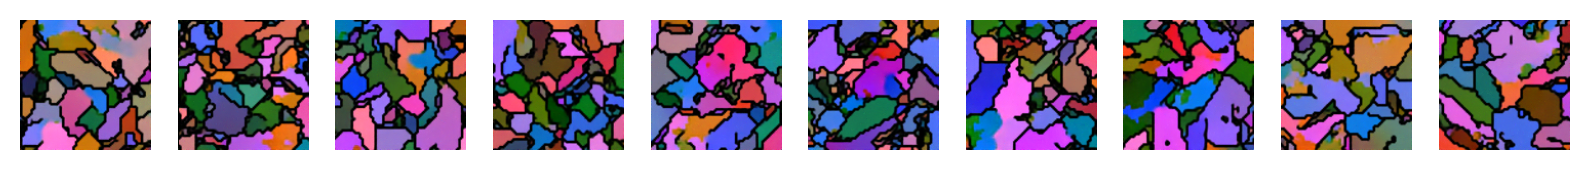

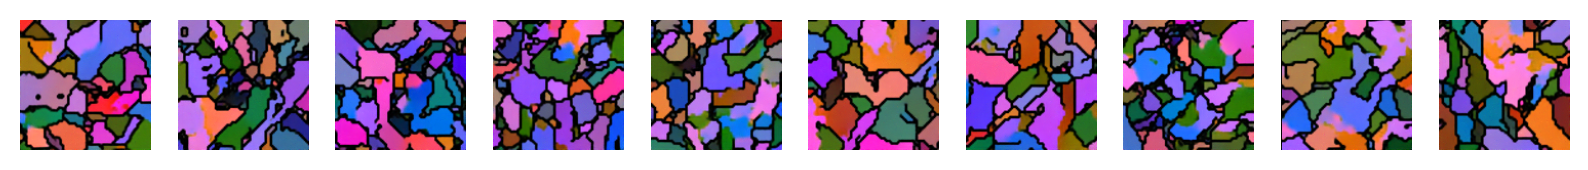

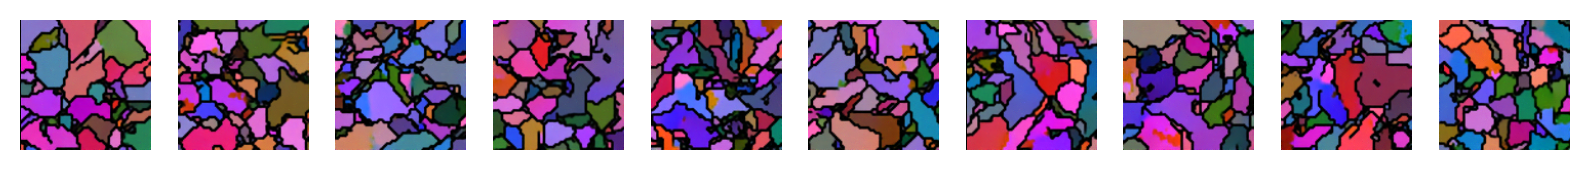

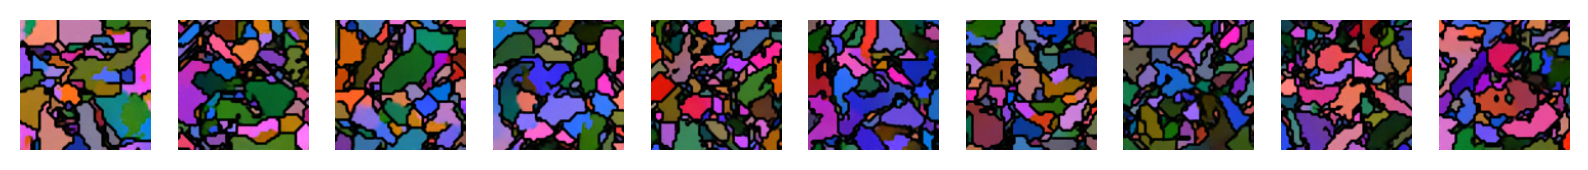

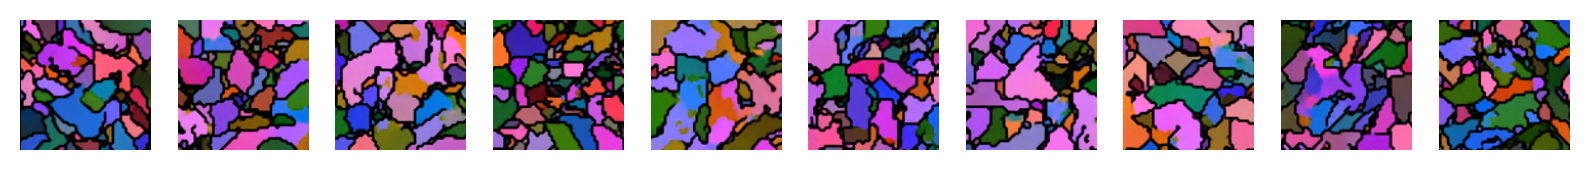

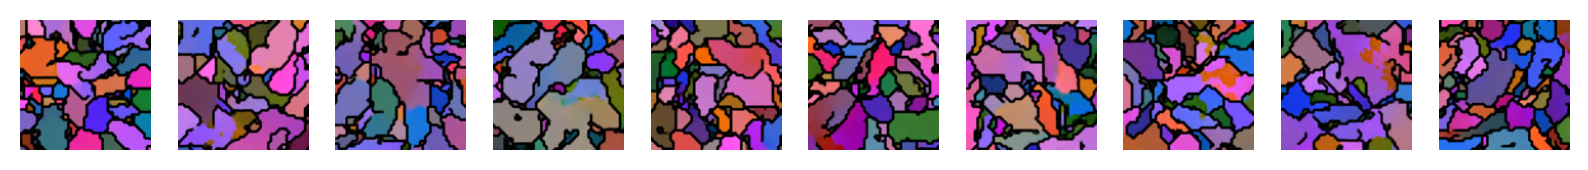

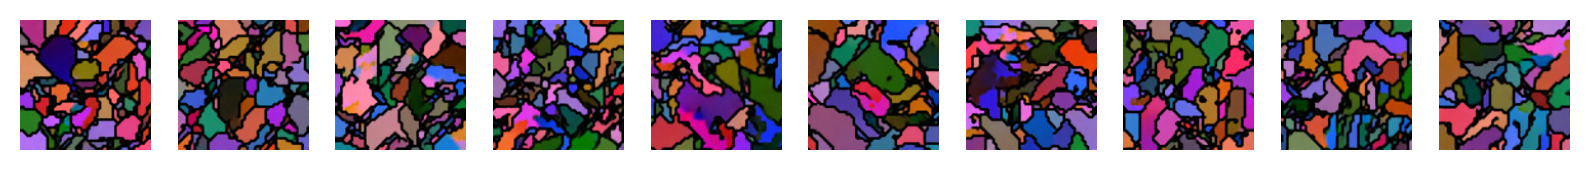

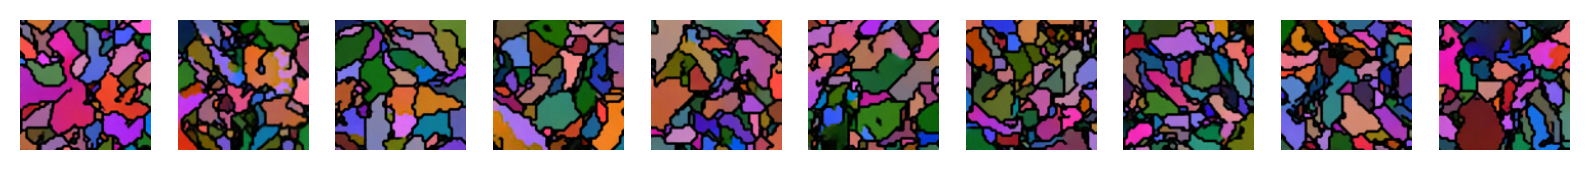

In [22]:
with torch.no_grad():
    vae.to(device)
    vae.eval()
    
    diffusion.to(device)
    diffusion.eval()
    new_imgaes = []
    for i in range(0, 10, 1):
        z = torch.tensor(z_pateto[i, :, :].T, dtype=torch.float32).to(device)
        image_vae = vae.decode(z)
        _, pred_image = generate(80, 'cuda', image_vae)
        new_imgaes.append(pred_image)
        show(pred_image[:10])

### Candidate microstructure selection

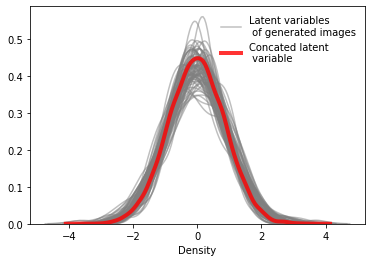

In [23]:
plt.figure()
index = 1 #Selected alloy
for i in range(80):
    sns.kdeplot(z_pateto[index][:,i], color="grey", alpha=0.5)
sns.kdeplot(z_pateto[index][:,1], color="grey", alpha=0.5, label="Latent variables\n of generated images")
sns.kdeplot(z_pateto[index].flatten(), linewidth=4, color="red", alpha=0.8, label="Concated latent\n variable")

plt.xlabel("Density")
plt.legend(loc='best', frameon=False)
plt.show()

In [24]:
from scipy.stats import wasserstein_distance
data_1 = torch.from_numpy(z_pateto[index].flatten())
data_2 = torch.from_numpy(z_pateto[index][:,0])


In [25]:
wd_list = []
for i in range(80):
    data_2 = z_pateto[index][:,i]
    wd = wasserstein_distance(data_1, data_2)
    wd_list.append(wd)

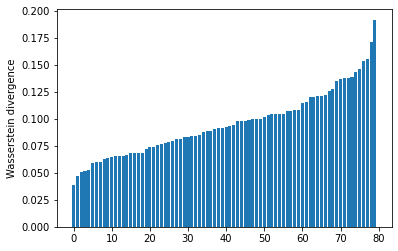

In [26]:
plt.figure()
sorted_indices = np.argsort(wd_list)
sorted_categories = [wd_list[i] for i in sorted_indices]
plt.bar(range(80), sorted_categories)
plt.ylabel("Wasserstein divergence")
plt.show()

In [29]:
selected_images = new_imgaes[index][np.argsort(np.array(wd_list))[:10]]

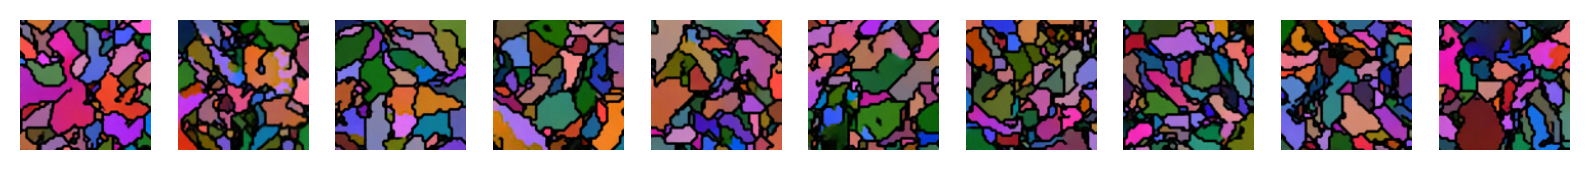

In [31]:
show(selected_images)